In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import joblib
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.__version__

'3.8.1'

In [2]:
data=pd.read_json('/content/question_answer.json')
#data.index=np.arange(1,503)
data.head(20)

,question,answer
0,What types of loans are offered by the bank?,"The bank provides various loans, including per..."
1,How is the interest rate decided for a loan?,The interest rate depends on the loan type and...
2,Can you explain how interest on the loan is ca...,"Interest can be simple or compound, and it var..."
3,How long do I have to repay the loan?,Loan terms differ. Personal loans usually have...
4,Will I be charged extra if I pay off the loan ...,Some loans have fees for early repayment. It's...
5,What documents do I need to apply for a loan?,"You usually need proof of income, work details..."
6,How long does it take to know if my loan is ap...,The approval time varies based on the loan typ...
7,What's the lowest credit score accepted for a ...,The minimum credit score needed varies based o...
8,Do I have to offer something valuable to get a...,Whether you need collateral depends on the typ...
9,Can I use the loan money for anything I want?,The way you use the loan may depend on the loa...


In [3]:
data['tags']=None
tags_for_loan=['Personal Loans','Interest Rate','Interest Calculation','Loan Duration','Extra Charges','Loan Application',
      'Loan Approval','Credit Score','Collateral','Loan Usage','Late Payment','Loan Terms','Fixed-Rate Loan',
      'Early Payment','Loan Disbursement','Loan Discounts','Online Application','Payment Assistance','Loan Insurance','Loan Refinancing']
tags_for_card=['Bank Cards','Card Application','Eligibility Criteria','Cards Difference','Annual Fee','Card Activation',
               'Lost Card','PIN Setup','Withdrawal Limits','online Purchases','Dispute','Card Benefits','Foreign Transaction',
               'Account Alerts','Grace Period','Authorized Users','Credit Card Limit','Security Measures',' Linking Cards','Card Transaction']
tags_for_app=['App Installation','App Features','App Compatibility','App Login','Account Notification','Password Recovery','App Security',
              'App Deposit Check','App Transfer Procedure','App Fees','Bill Payment','Technical Glitches',' Account Settings','Mobile App Limits',
              'Contact Details Update','App Transaction Access','Password Change']
tags_for_transfer=['Money Tranfer','Bank Transfer','Tranfer Fees','Processing Time','Recurring Transfers','Transfer Limits','Cancellation Transfer',
                   'Transfer Without Account','Track Money Transfer','Wire and ACH','Transfer Notification','Transfer Security','International Transfer',
                   'Incorrect Information','Online Banking','InterBank Transfer','Domestic and International','Transfer Purpose','Phone Transfer']
tags_for_deposit=['Deposit','Deposit Information','Deposit Fees','Deposit Types','Deposit Limits','Check Deposit','Clear Checked Deposit',
                  'Cash Deposit','Incentives or Bonuses','Automatic Deposit','Deposit Issue','Foreign Currency','Deposit Insurance','ATM Deposit',
                  'Savings Account','Third-Party Check','Remote Deposit','Bounced Check','Individual Account','Deposit History']
tags_for_greeting=['Greetings']
index_loan=[0,20,40,60,80]
index_card=[100,120,140,160,180]
index_app=[200,217,234,251,268]
index_transfer=[285,304,323,342,361]
index_deposit=[380,400,420,440,460]
#data.tags.iloc[nums]=tags_type[0]
#for n in range(1,20):
  #nums=[num+1 for num in nums]
  #data.tags.iloc[nums]=tags_type[n]

def tag_creating(initial_index,tags_type,quest_range):
  data.tags.iloc[initial_index]=tags_type[0]
  for n in range(1,quest_range):
    initial_index=[num+1 for num in initial_index]
    data.tags.iloc[initial_index]=tags_type[n]
tag_creating(index_loan,tags_for_loan,quest_range=20)
tag_creating(index_card,tags_for_card,quest_range=20)
tag_creating(index_app,tags_for_app,quest_range=17)
tag_creating(index_transfer,tags_for_transfer,quest_range=19)
tag_creating(index_deposit,tags_for_deposit,quest_range=20)
data.tags.iloc[480:]='Greetings'

In [4]:
data['intent']=None
data['intent'].iloc[:100]='loans'
data['intent'].iloc[100:200]='cards'
data['intent'].iloc[200:285]='mobile app'
data['intent'].iloc[285:380]='money transfer'
data['intent'].iloc[380:480]='deposits'
data['intent'].iloc[480:]='greeting'

In [5]:
data=data.sample(frac=1,random_state=25)
data.index=np.arange(0,502)

In [30]:
data.tail(10)

,question,answer,tags,intent,label_tag,label_intent,words
492,How do savings and checking accounts differ co...,While both savings and checking accounts facil...,Savings Account,deposits,83,1,how saving checking account differ concerning ...
493,Are there any incentives or advantages for dep...,Certain banks extend incentives or advantages ...,Incentives or Bonuses,deposits,52,1,are incentive advantage depositing substantial...
494,What good things come with my credit card?,Credit cards often give you benefits like mone...,Card Benefits,cards,24,0,what good thing come credit card
495,Can I customize alerts for my account through ...,"Absolutely, the mobile app typically allows yo...",Account Notification,mobile app,4,4,can i customize alert account mobile app
496,What happens if I provide incorrect informatio...,Providing incorrect information can result in ...,Incorrect Information,money transfer,53,5,what happens i provide incorrect information m...
497,What happens if I provide inaccurate informati...,Providing incorrect details can lead to delays...,Incorrect Information,money transfer,53,5,what happens i provide inaccurate information ...
498,How is a credit card different from a debit card?,"With a credit card, you can borrow money up to...",Cards Difference,cards,26,0,how credit card different debit card
499,What is the difference between a savings accou...,A savings account is typically designed for sa...,Savings Account,deposits,83,1,what difference saving account checking accoun...
500,Is it secure to use online banking or mobile a...,"Yes, online banking and mobile apps use secure...",Online Banking,money transfer,73,5,is secure use online banking mobile apps money...
501,Will there be extra charges for using my bank ...,Some bank cards may incur fees for foreign tra...,Foreign Transaction,cards,49,0,will extra charge using bank card foreign country


In [7]:
encoder=LabelEncoder()
data['label_tag']=encoder.fit_transform(data[['tags']])
data['label_intent']=encoder.fit_transform(data[['intent']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
def get_prep_words(sample_quest):
  tokenizer=WordPunctTokenizer()
  tokenized=tokenizer.tokenize(sample_quest)
  lemmatizer=WordNetLemmatizer()
  stop_words=stopwords.words('english')
  stop_words.extend(['?','!',"'"])
  non_stop_words=[word.lower() for word in tokenized if word not in stop_words]
  base_words=[lemmatizer.lemmatize(word) for word in non_stop_words]
  return ' '.join(base_words)
data['words']=data.question.apply(get_prep_words)

In [9]:
len(data.label_tag.unique())

97

In [10]:
X_values=np.array(data.words.tolist())
y_values=np.array(data.label_tag.tolist())
train_X,test_X,train_y,test_y=train_test_split(X_values,y_values,test_size=0.2,
                                               stratify=y_values,random_state=23)

In [11]:
vectorizer=TfidfVectorizer()
train_X_vector=vectorizer.fit_transform(train_X).toarray()
test_X_vector=vectorizer.transform(test_X).toarray()

In [12]:
data.head()

,question,answer,tags,intent,label_tag,label_intent,words
0,Are there charges associated with utilizing th...,Certain banks may impose fees for utilizing th...,Remote Deposit,deposits,82,1,are charge associated utilizing bank remote de...
1,Are there any fees associated with making a de...,Most banks do not charge fees for making depos...,Deposit Fees,deposits,35,1,are fee associated making deposit
2,Do I have to buy insurance for the loan?,Insurance needs can be different for each loan...,Loan Insurance,loans,65,3,do i buy insurance loan
3,If I forget my mobile app password or username...,"In case you forget your password or username, ...",Password Recovery,mobile app,76,4,"if i forget mobile app password username , pro..."
4,What is the daily or monthly limit for money t...,Banks often impose limits on the amount you ca...,Transfer Limits,money transfer,89,5,what daily monthly limit money transfer account


In [13]:
class Model_Accuracy:
  def __init__(self,model_type,train_X,train_y,test_X,test_y):
    self.model=model_type
    self.train_X=train_X
    self.test_X=test_X
    self.train_y=train_y
    self.test_y=test_y

  def get_prediction(self):
    self.model.fit(self.train_X,self.train_y)
    return self.model.predict(self.test_X)

  def get_accuracy(self):
    pred=self.get_prediction()
    return accuracy_score(self.test_y,pred)

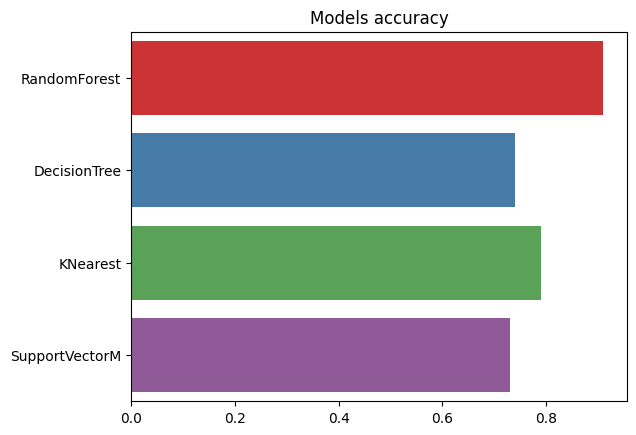

RandomForest accuracy:0.91
DecisionTree accuracy:0.74
KNearest accuracy:0.79
SupportVectorM accuracy:0.73


In [14]:
RF=RandomForestClassifier(random_state=23)
DT=DecisionTreeClassifier(random_state=23)
KNN=KNeighborsClassifier(n_neighbors=3)
SVM=SVC()
models=[RF,DT,KNN,SVM]
accuracy_result=[]
for model in models:
  model_evol=Model_Accuracy(model,train_X_vector,train_y,test_X_vector,test_y)
  accuracy_result.append(np.round(model_evol.get_accuracy(),2))
model_type=['RandomForest','DecisionTree','KNearest','SupportVectorM']
sns.barplot(y=model_type,x=accuracy_result,hue=model_type,palette='Set1')
plt.title('Models accuracy')
plt.show()
for model,acc in zip(model_type,accuracy_result):
  print(f"{model} accuracy:{acc}")

In [27]:
model = keras.Sequential()
model.add(Dense(256, input_shape=(train_X_vector.shape[1],), activation='relu'))
#model.add(layers.BatchNormalization())
model.add(Dropout(0.4))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(set(y_values)), activation='softmax'))

#sgd_optimizer=tf.keras.optimizers.SGD(learning_rate=0.003,momentum=0.2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback=ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True)
model.fit(train_X_vector, train_y,validation_data=(test_X_vector,test_y),
          callbacks=[callback],batch_size=16,epochs=200)
model_loaded=tf.keras.models.load_model('best_model.h5')
model_loaded.evaluate(test_X_vector, test_y,batch_size=16)

Epoch 1/200
26/26 [==============================] - 1s 11ms/step - loss: 4.5711 - accuracy: 0.0200 - val_loss: 4.5421 - val_accuracy: 0.0693
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 4.5203 - accuracy: 0.0698 - val_loss: 4.4892 - val_accuracy: 0.0693
Epoch 3/200
 1/26 [>.............................] - ETA: 0s - loss: 4.4179 - accuracy: 0.1250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 5ms/step - loss: 4.4405 - accuracy: 0.0873 - val_loss: 4.3911 - val_accuracy: 0.0495
Epoch 4/200
26/26 [==============================] - 0s 5ms/step - loss: 4.3119 - accuracy: 0.0648 - val_loss: 4.2363 - val_accuracy: 0.0495
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 4.1155 - accuracy: 0.0599 - val_loss: 4.0204 - val_accuracy: 0.0495
Epoch 6/200
26/26 [==============================] - 0s 4ms/step - loss: 3.8580 - accuracy: 0.0673 - val_loss: 3.7422 - val_accuracy: 0.0594
Epoch 7/200
26/26 [==============================] - 0s 5ms/step - loss: 3.5324 - accuracy: 0.1845 - val_loss: 3.3895 - val_accuracy: 0.2178
Epoch 8/200
26/26 [==============================] - 0s 6ms/step - loss: 3.1171 - accuracy: 0.3890 - val_loss: 2.9579 - val_accuracy: 0.6436
Epoch 9/200
26/26 [==============================] - 0s 5ms/step - loss: 2.6541 - accuracy: 0.5985 - val_loss: 2.4799 - val_accuracy: 0.7327
Epoch 10/200
26/26 [=====

[0.32957929372787476, 0.9405940771102905]

In [34]:
input='Can I trust the security of online banking or mobile apps when making money transfers?'
input_tfidf=vectorizer.transform([input]).toarray()
np.argmax(model.predict(input_tfidf))

1/1 [==============================] - 0s 26ms/step


73

In [35]:
data[data.label_tag==73]

,question,answer,tags,intent,label_tag,label_intent,words
12,Is it safe to use online banking or apps for t...,"Yes, using online banking or apps to transfer ...",Online Banking,money transfer,73,5,is safe use online banking apps transferring m...
28,Is it safe to use online banking or mobile app...,"Yes, online banking and mobile apps use secure...",Online Banking,money transfer,73,5,is safe use online banking mobile apps money t...
53,Is it safe to rely on online banking or mobile...,"Yes, online banking and mobile apps utilize se...",Online Banking,money transfer,73,5,is safe rely online banking mobile apps execut...
238,Is it safe to use online banking or apps for m...,"Yes, using online banking or mobile apps for m...",Online Banking,money transfer,73,5,is safe use online banking apps money transfer
500,Is it secure to use online banking or mobile a...,"Yes, online banking and mobile apps use secure...",Online Banking,money transfer,73,5,is secure use online banking mobile apps money...


In [19]:
tokenizer=Tokenizer(num_words=500,oov_token='<OOV>')
tokenizer.fit_on_texts(train_X)
indexed_words=tokenizer.word_index
train_sequences=tokenizer.texts_to_sequences(train_X)
train_padded=pad_sequences(train_sequences,maxlen=10,padding='post',truncating='post')
test_sequences=tokenizer.texts_to_sequences(test_X)
test_padded=pad_sequences(test_sequences,maxlen=10,padding='post',truncating='post')

In [20]:
train_X_vector.shape

(401, 447)

In [21]:
model=keras.Sequential()
model.add(Embedding(input_dim=500,output_dim=32,input_length=10))
model.add(layers.GlobalAveragePooling1D())
model.add(Dense(256,activation='relu',use_bias=True))
#model.add(layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu',use_bias=True))
model.add(Dropout(0.4))
model.add(Dense(len(set(y_values)),activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_padded,train_y,epochs=200,verbose=2)
model.evaluate(test_padded,test_y,verbose=2)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 - 3s - loss: 4.5753 - accuracy: 0.0200 - 3s/epoch - 239ms/step
Epoch 2/200
13/13 - 1s - loss: 4.5695 - accuracy: 0.0424 - 1s/epoch - 92ms/step
Epoch 3/200
13/13 - 0s - loss: 4.5605 - accuracy: 0.0424 - 331ms/epoch - 25ms/step
Epoch 4/200
13/13 - 1s - loss: 4.5429 - accuracy: 0.0424 - 759ms/epoch - 58ms/step
Epoch 5/200
13/13 - 0s - loss: 4.4984 - accuracy: 0.0424 - 330ms/epoch - 25ms/step
Epoch 6/200
13/13 - 1s - loss: 4.4212 - accuracy: 0.0449 - 625ms/epoch - 48ms/step
Epoch 7/200
13/13 - 1s - loss: 4.3441 - accuracy: 0.0499 - 621ms/epoch - 48ms/step
Epoch 8/200
13/13 - 0s - loss: 4.2766 - accuracy: 0.0673 - 49ms/epoch - 4ms/step
Epoch 9/200
13/13 - 0s - loss: 4.1972 - accuracy: 0.0748 - 493ms/epoch - 38ms/step
Epoch 10/200
13/13 - 0s - loss: 4.1029 - accuracy: 0.0723 - 49ms/epoch - 4ms/step
Epoch 11/200
13/13 - 0s - loss: 3.9891 - accuracy: 0.0748 - 186ms/epoch - 14ms/step
Epoch 12/200
13/13 - 0s - loss: 3.8788 - accuracy: 0.0748 - 189ms/epoch - 15ms/step
Epoch 13/200
13/13 - 0

[0.7269555330276489, 0.8910890817642212]

In [22]:
input='How can I recover my mobile app password or username if I happen to forget them?'
inp=get_prep_words(input)
prep=vectorizer.transform([inp]).toarray()
tag_value=np.argmax(model_loaded.predict(prep))
np.random.choice(np.array(data[data.label_tag==tag_value].answer))

1/1 [==============================] - 0s 48ms/step


'If you forget your password or username, the app typically provides a recovery option. Follow the instructions on the login screen or reach out to customer support for assistance.'

In [23]:
joblib.dump(vectorizer,'tfidf_vectorizer.jbl')

['tfidf_vectorizer.jbl']

In [24]:
data.to_csv('question_answer.csv')

In [25]:
train_X_vector.shape

(401, 447)